In [1]:
import h2o
from h2o.automl import H2OAutoML

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
from datetime import datetime

from sklearn.svm import SVC

from vboUtil import eda, preprocessing

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans
from vboUtil import eda, preprocessing

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [9]:
df = train.copy()
df_test = test.copy()
df.drop_duplicates(inplace=True) # Train set has a lot of duplicates. Since timestamp with split seconds precision can't
# be same for different users and different actions, we drop all the duplicates.
df_test.drop_duplicates(inplace=True) # Same reason

In [10]:
df.isna().sum()

time_stamp                   0
contentid                    2
user_action                  0
sellingprice             32013
product_name              2184
brand_id                  2184
brand_name                2184
businessunit              2184
product_gender          234595
category_id               2184
Level1_Category_Id        2184
Level1_Category_Name      2184
Level2_Category_Id        2184
Level2_Category_Name      2184
Level3_Category_Id        2184
Level3_Category_Name      2184
gender                       0
unique_id                    0
type                         0
dtype: int64

In [11]:
df_test.isna().sum()

time_stamp                   0
contentid                    1
user_action                  0
sellingprice             14256
product_name               902
brand_id                   902
brand_name                 902
businessunit               902
product_gender          105229
category_id                902
Level1_Category_Id         902
Level1_Category_Name       902
Level2_Category_Id         902
Level2_Category_Name       902
Level3_Category_Id         902
Level3_Category_Name       902
gender                  877989
unique_id                    0
type                         0
dtype: int64

In [12]:
train_ids = df['unique_id']

In [13]:
len(df)

2077356

In [14]:
df['unique_id'].isin(df_test['unique_id'].unique()).any() # Train and Test sets have different unique_id values. (Checked)

False

In [15]:
df.head()# unique_id = customer_id

,time_stamp,contentid,user_action,sellingprice,product_name,brand_id,brand_name,businessunit,product_gender,category_id,Level1_Category_Id,Level1_Category_Name,Level2_Category_Id,Level2_Category_Name,Level3_Category_Id,Level3_Category_Name,gender,unique_id,type
0,2020-12-02T22:26:14.023Z,39918893.0,favorite,3099.0,PerfectCare 600 EW6F449ST A+++ 9 KG 1400 Devir...,8511.0,Electrolux,Beyaz Eşya,Unisex,1272.0,1071.0,Elektronik,1212.0,Beyaz Eşya,1272.0,Çamaşır Makinesi,F,425,train
1,2020-12-08T23:15:04.603Z,3558544.0,favorite,3079.0,WW90J5475FW A+++ 1400 Devir 9 kg Çamaşır Makinesi,3228.0,Samsung,Beyaz Eşya,NaN,1272.0,1071.0,Elektronik,1212.0,Beyaz Eşya,1272.0,Çamaşır Makinesi,F,425,train
2,2020-12-05T16:19:01.157Z,31292729.0,favorite,3999.0,KM 9711 A++ 9 kg Çamaşır Kurutma Makinesi,10989.0,Vestel,Beyaz Eşya,Unisex,1276.0,1071.0,Elektronik,1212.0,Beyaz Eşya,1276.0,Kurutma Makinesi,F,425,train
3,2020-12-05T16:28:00Z,6363103.0,visit,2544.0,CMI 9710 A+++ 1000 Devir 9 kg Çamaşır Makinesi,10989.0,Vestel,Beyaz Eşya,NaN,1272.0,1071.0,Elektronik,1212.0,Beyaz Eşya,1272.0,Çamaşır Makinesi,F,425,train
4,2020-12-02T22:26:59Z,39918893.0,visit,3099.0,PerfectCare 600 EW6F449ST A+++ 9 KG 1400 Devir...,8511.0,Electrolux,Beyaz Eşya,Unisex,1272.0,1071.0,Elektronik,1212.0,Beyaz Eşya,1272.0,Çamaşır Makinesi,F,425,train


In [16]:
a = df.groupby('brand_id')['brand_name'].nunique() # 4 brand_id has more than 1 brand_name.
a[a>1]

brand_id
34614.0     2
110447.0    2
966197.0    2
998446.0    2
Name: brand_name, dtype: int64

In [17]:
a = df.groupby('brand_name')['brand_id'].nunique() # Each brand_name has a unique brand_id
a[a>1]

Series([], Name: brand_id, dtype: int64)

In [18]:
df['brand_name'].nunique() #33332
df['brand_id'].nunique() #33328

33328

In [19]:
# brand_name is more unique. Therefore, brand_id could be dropped.

In [20]:
(df['brand_name'].isnull() == df['brand_id'].isnull()).all() # Their NA values are in the same rows.

True

In [21]:
len(df['contentid'].value_counts()) # It has a lot of levels, therefore, it is safe to drop it. (It is an id anyways,
# unlikely to provide info.)

482796

In [22]:
a = df.groupby('Level1_Category_Id')['Level1_Category_Name'].nunique()
a[a>1] # Each Level1_Category_Id correspond to a unique Level1_Category_Name. Level1_Category_Name should be dropped.

Series([], Name: Level1_Category_Name, dtype: int64)

In [23]:
a = df.groupby('Level2_Category_Id')['Level2_Category_Name'].nunique()
a[a>1] # # Each Level2_Category_Id correspond to a unique Level2_Category_Name. Level2_Category_Name should be dropped.

Series([], Name: Level2_Category_Name, dtype: int64)

In [24]:
a = df.groupby('Level3_Category_Id')['Level3_Category_Name'].nunique()
a[a>1] # Each Level3_Category_Id correspond to a unique Level3_Category_Name. Level3_Category_Name should be dropped.

Series([], Name: Level3_Category_Name, dtype: int64)

In [25]:
df[['category_id', 'Level3_Category_Id']] # category_id and Level3_Category_Id seem similar.

,category_id,Level3_Category_Id
0,1272.0,1272.0
1,1272.0,1272.0
2,1276.0,1276.0
3,1272.0,1272.0
4,1272.0,1272.0
...,...,...
5493263,864.0,864.0
5493264,1186.0,1186.0
5493265,864.0,864.0
5493266,975.0,975.0


In [26]:
a = df.groupby('Level3_Category_Id')['category_id'].nunique()
a[a>1] # There are levels of Level3_Category_Id that correspond to more than one category_id.

Level3_Category_Id
397.0      6
399.0      7
400.0      6
401.0      6
469.0      2
          ..
4540.0    13
4569.0    11
4588.0     2
4589.0    39
4591.0    11
Name: category_id, Length: 166, dtype: int64

In [27]:
a = df.groupby('category_id')['Level3_Category_Id'].nunique()
a[a>1] # Each category_id correspond to a unique Level3_Category_Id.

Series([], Name: Level3_Category_Id, dtype: int64)

In [28]:
df['category_id'].nunique() #2240
df['Level3_Category_Id'].nunique() #739

739

In [29]:
(df['category_id'].isna() == df['Level3_Category_Id'].isna()).all() # Rows that they are missing are the same.
# Therefore, since the category_id is more unique and they provide the same information
# Level3_Category_Id is dropped.

True

In [30]:
# Drop the columns that we decided to drop before.
# Type column is not necessary at this point, therefore we can drop it as well.

df = train.drop(['contentid', 'Level1_Category_Name', 'Level2_Category_Name', 'Level3_Category_Name',
        'Level3_Category_Id', 'brand_id', 'type'], axis=1)
df.drop_duplicates(inplace=True)
df_test = test.drop(['contentid', 'Level1_Category_Name', 'Level2_Category_Name', 'Level3_Category_Name',
        'Level3_Category_Id', 'brand_id', 'type'], axis=1)
df_test.drop('gender', inplace=True, axis=1) # Gender column is dropped because it is the target feature and full of NA's.
df_test.drop_duplicates(inplace=True)

In [31]:
test_ids = df_test['unique_id']
train_ids = df['unique_id']

In [32]:
df['user_action'].value_counts() 

visit       1027149
search       771374
favorite     156204
basket        99102
order         23299
Name: user_action, dtype: int64

In [33]:
df.isnull().any()

time_stamp            False
user_action           False
sellingprice           True
product_name           True
brand_name             True
businessunit           True
product_gender         True
category_id            True
Level1_Category_Id     True
Level2_Category_Id     True
gender                False
unique_id             False
dtype: bool

In [34]:
len(df) #2077128

2077128

In [35]:
df.isnull().sum()

time_stamp                 0
user_action                0
sellingprice           32012
product_name            2184
brand_name              2184
businessunit            2184
product_gender        234567
category_id             2184
Level1_Category_Id      2184
Level2_Category_Id      2184
gender                     0
unique_id                  0
dtype: int64

In [36]:
df.isnull().sum()/len(df) # There are very few product-related missing columns.

time_stamp            0.000000
user_action           0.000000
sellingprice          0.015412
product_name          0.001051
brand_name            0.001051
businessunit          0.001051
product_gender        0.112929
category_id           0.001051
Level1_Category_Id    0.001051
Level2_Category_Id    0.001051
gender                0.000000
unique_id             0.000000
dtype: float64

In [37]:
df_test.isnull().sum()

time_stamp                 0
user_action                0
sellingprice           14255
product_name             902
brand_name               902
businessunit             902
product_gender        105213
category_id              902
Level1_Category_Id       902
Level2_Category_Id       902
unique_id                  0
dtype: int64

In [38]:
s = df_test.notnull().all(axis=1)

In [39]:
notnull = s[s].index

In [40]:
len(df_test.unique_id.unique())

2380

In [41]:
len(df_test.loc[notnull,:].unique_id.unique()) # There are 2380-2331 = 49 unique_id values that has at least 1 missing value
# in their features, therefore we can't directly drop rows with missing values and apply majority voting.

2331

In [42]:
df[df['product_name'].isnull()].notnull().any() #product_name, brand_name, business_unit, category_id, Level1_Category_Id
# and Level2_Category_Id missing values are in the same rows. There are 2184 of these rows.

time_stamp             True
user_action            True
sellingprice           True
product_name          False
brand_name            False
businessunit          False
product_gender        False
category_id           False
Level1_Category_Id    False
Level2_Category_Id    False
gender                 True
unique_id              True
dtype: bool

In [43]:
df_test[df_test['product_name'].notnull()]['unique_id'].nunique() # We can't drop the product-related rows as well. (1 unique_id is lost that way)

2379

In [44]:
df[~(df['product_name'].notnull())]['sellingprice'].isnull().any() # True
df[~(df['product_name'].notnull())]['product_gender'].isnull().any() # True
# Both sellingprice and product_gender missing values overlap with product-related columns' missing values at some rows.
# Therefore, we can't use these values to impute missing values of each other.

True

## I will be filling the brand-related values with their most frequent values, as they are not that frequent anyways. Then, I will impute sellingprice, using rf. Lastly, I will impute productgender, using rf. Before imputations, I will create isNA columns to state that they were NA beforehand.

In [45]:
df[~(df['product_name'].notnull())]

,time_stamp,user_action,sellingprice,product_name,brand_name,businessunit,product_gender,category_id,Level1_Category_Id,Level2_Category_Id,gender,unique_id
10182,2020-11-27T06:40:58Z,visit,65.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,1983
17988,2020-10-21T21:52:56Z,visit,563.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,737
17989,2020-10-21T21:51:38Z,visit,563.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,737
18724,2020-10-22T19:36:40Z,visit,563.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,737
20323,2020-10-21T21:52:00Z,visit,563.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,737
...,...,...,...,...,...,...,...,...,...,...,...,...
5483497,2020-11-28T13:36:52Z,search,559.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,5457
5484856,2020-11-27T23:51:26Z,visit,99.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,3071
5487463,2020-11-29T10:16:38Z,basket,109.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,3354
5487465,2020-11-29T10:16:25Z,visit,109.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,3354


In [46]:
df[~(df['product_name'].notnull())]['user_action'].value_counts()

visit       1100
search       826
basket       120
favorite     102
order         36
Name: user_action, dtype: int64

In [47]:
df[(df['product_name'].notnull())]['user_action'].value_counts() # Missing values are not due to the nature of any action.

visit       1026049
search       770548
favorite     156102
basket        98982
order         23263
Name: user_action, dtype: int64

In [48]:
# Convert TZ timestamp to datetime64 object

df['timestamp_dt'] = df.apply(lambda x: datetime.fromisoformat(x['time_stamp'].strip('Z')), axis=1)
df_test['timestamp_dt'] = df_test.apply(lambda x: datetime.fromisoformat(x['time_stamp'].strip('Z')), axis=1)

df.drop('time_stamp', axis=1, inplace=True)
df_test.drop('time_stamp', axis=1, inplace=True)

In [49]:
df['timestamp_dt'].min()  # 2020-10-14
df['timestamp_dt'].max()  # 2020-12-09

df_test['timestamp_dt'].min()  # 2020-10-14
df_test['timestamp_dt'].max()  # 2020-12-09
# Data is collected between October 14 and December 9, 2020

Timestamp('2020-12-09 13:29:58')

In [50]:
# I will be creating new variables month, day, day_name hour and minute. I believe that minute and day will not be 
# significant but we can decide it later.

df['weekday'] = df['timestamp_dt'].apply(lambda x: x.weekday())
#df['day'] = df['timestamp_dt'].apply(lambda x: x.day)    - Computationally expensive, creates extra 30 rows.
df['month'] = df['timestamp_dt'].apply(lambda x: x.month)
df['hour'] = df['timestamp_dt'].apply(lambda x: x.hour)
df['minute'] = df['timestamp_dt'].apply(lambda x: x.minute) # Computationally expensive, probably unimportant.

df.drop(['timestamp_dt', 'unique_id'], axis=1, inplace=True) # Not needed anymore

df_test['weekday'] = df_test['timestamp_dt'].apply(lambda x: x.weekday())
#df_test['day'] = df_test['timestamp_dt'].apply(lambda x: x.day)
df_test['month'] = df_test['timestamp_dt'].apply(lambda x: x.month)
df_test['hour'] = df_test['timestamp_dt'].apply(lambda x: x.hour)
df_test['minute'] = df_test['timestamp_dt'].apply(lambda x: x.minute)

df_test.drop(['timestamp_dt', 'unique_id'], axis=1, inplace=True) # Not needed anymore

In [51]:
df.head()

,user_action,sellingprice,product_name,brand_name,businessunit,product_gender,category_id,Level1_Category_Id,Level2_Category_Id,gender,weekday,month,hour,minute
0,favorite,3099.0,PerfectCare 600 EW6F449ST A+++ 9 KG 1400 Devir...,Electrolux,Beyaz Eşya,Unisex,1272.0,1071.0,1212.0,F,2,12,22,26
1,favorite,3079.0,WW90J5475FW A+++ 1400 Devir 9 kg Çamaşır Makinesi,Samsung,Beyaz Eşya,NaN,1272.0,1071.0,1212.0,F,1,12,23,15
2,favorite,3999.0,KM 9711 A++ 9 kg Çamaşır Kurutma Makinesi,Vestel,Beyaz Eşya,Unisex,1276.0,1071.0,1212.0,F,5,12,16,19
3,visit,2544.0,CMI 9710 A+++ 1000 Devir 9 kg Çamaşır Makinesi,Vestel,Beyaz Eşya,NaN,1272.0,1071.0,1212.0,F,5,12,16,28
4,visit,3099.0,PerfectCare 600 EW6F449ST A+++ 9 KG 1400 Devir...,Electrolux,Beyaz Eşya,Unisex,1272.0,1071.0,1212.0,F,2,12,22,26


In [52]:
# Create FLAG_weekend variable

df['FLAG_weekend'] = df.apply(lambda x: 1 if x['weekday']>=5 else 0, axis=1)

df_test['FLAG_weekend'] = df_test.apply(lambda x: 1 if x['weekday']>=5 else 0, axis=1)

In [53]:
# Fill the product cols with the most frequent values

product_cols = ['product_name', 'brand_name', 'businessunit', 'category_id', 'Level1_Category_Id', 'Level2_Category_Id']

# Save the most frequent cols to use for test missing values as well

frequent_values = []

for col in product_cols:
    frequent_values.append(df[col].value_counts().sort_values().index[-1])

# Fill the train set missing values
for col in product_cols:
    df[col].fillna(df[col].value_counts().sort_values().index[-1], inplace=True)
    
# Fill the test set missing values
i=0

for col in product_cols:
    df_test[col].fillna(frequent_values[i], inplace=True)
    i+=1

In [54]:
df.isnull().sum()

user_action                0
sellingprice           32012
product_name               0
brand_name                 0
businessunit               0
product_gender        234567
category_id                0
Level1_Category_Id         0
Level2_Category_Id         0
gender                     0
weekday                    0
month                      0
hour                       0
minute                     0
FLAG_weekend               0
dtype: int64

In [55]:
df_test.isnull().sum()

user_action                0
sellingprice           14255
product_name               0
brand_name                 0
businessunit               0
product_gender        105213
category_id                0
Level1_Category_Id         0
Level2_Category_Id         0
weekday                    0
month                      0
hour                       0
minute                     0
FLAG_weekend               0
dtype: int64

In [56]:
# Checkpoint

df_1 = df.copy().drop('gender', axis=1)
df_test_1 = df_test.copy()

In [57]:
df_1.head()

,user_action,sellingprice,product_name,brand_name,businessunit,product_gender,category_id,Level1_Category_Id,Level2_Category_Id,weekday,month,hour,minute,FLAG_weekend
0,favorite,3099.0,PerfectCare 600 EW6F449ST A+++ 9 KG 1400 Devir...,Electrolux,Beyaz Eşya,Unisex,1272.0,1071.0,1212.0,2,12,22,26,0
1,favorite,3079.0,WW90J5475FW A+++ 1400 Devir 9 kg Çamaşır Makinesi,Samsung,Beyaz Eşya,NaN,1272.0,1071.0,1212.0,1,12,23,15,0
2,favorite,3999.0,KM 9711 A++ 9 kg Çamaşır Kurutma Makinesi,Vestel,Beyaz Eşya,Unisex,1276.0,1071.0,1212.0,5,12,16,19,1
3,visit,2544.0,CMI 9710 A+++ 1000 Devir 9 kg Çamaşır Makinesi,Vestel,Beyaz Eşya,NaN,1272.0,1071.0,1212.0,5,12,16,28,1
4,visit,3099.0,PerfectCare 600 EW6F449ST A+++ 9 KG 1400 Devir...,Electrolux,Beyaz Eşya,Unisex,1272.0,1071.0,1212.0,2,12,22,26,0


In [58]:
# Need to do Rare Encoding before Label Encoding

In [59]:
a = df_1.nunique()
b = df_test_1.nunique()

In [60]:
print("Unique Values".rjust(34))
print("-------------".rjust(34))
print("train".rjust(26), "test".rjust(6))
print("-------------".rjust(34))
for i in range(len(a)):
    print(a.index[i].ljust(20), str(a[i]).ljust(6), b[i])

                     Unique Values
                     -------------
                     train   test
                     -------------
user_action          5      5
sellingprice         35433  24356
product_name         441470 239085
brand_name           33332  23943
businessunit         83     83
product_gender       3      3
category_id          2240   2022
Level1_Category_Id   10     10
Level2_Category_Id   95     94
weekday              7      7
month                3      3
hour                 24     24
minute               60     60
FLAG_weekend         2      2


In [61]:
# Some categorical features have different unique values in train and test. Therefore, we should label the ones that
# are not in the intersection as "Other".

In [62]:
product_name_outliers = set(df_1['product_name'].dropna()).union(set(df_test_1['product_name'].dropna()))-\
set(df_1['product_name'].dropna()).intersection(set(df_test_1['product_name'].dropna()))
len(product_name_outliers)
# Product name has around 427000 different values. This category is probably useless, considering that only
# around 250000 of the values are common in both data sets.

427659

In [63]:
brand_name_outliers = set(df_1['brand_name'].dropna()).union(set(df_test_1['brand_name'].dropna()))-\
set(df_1['brand_name'].dropna()).intersection(set(df_test_1['brand_name'].dropna()))
len(brand_name_outliers)
# brand_name_outliers have 17627 different values. This also looks like it will not be useful. We will see.

17627

In [64]:
category_id_outliers = set(df_1['category_id'].dropna()).union(set(df_test_1['category_id'].dropna()))-\
set(df_1['category_id'].dropna()).intersection(set(df_test_1['category_id'].dropna()))
len(category_id_outliers)
# category_id_outliers have different values

376

In [65]:
level2_outliers = set(df_1['Level2_Category_Id'].dropna()).union(set(df_test_1['Level2_Category_Id'].dropna()))-\
set(df_1['Level2_Category_Id'].dropna()).intersection(set(df_test_1['Level2_Category_Id'].dropna()))
level2_outliers # Level2 has different levels

{2901.0, 4530.0, 4572.0}

In [66]:
set(df_1['Level1_Category_Id'].dropna()).union(set(df_test_1['Level1_Category_Id'].dropna()))-\
set(df_1['Level1_Category_Id'].dropna()).intersection(set(df_test_1['Level1_Category_Id'].dropna()))
# Level1 is fine

set()

In [67]:
set(df_1['businessunit'].dropna()).union(set(df_test_1['businessunit'].dropna()))-\
set(df_1['businessunit'].dropna()).intersection(set(df_test_1['businessunit'].dropna()))
# businessunit is fine

set()

In [68]:
df_1['type'] = 'train'
df_test_1['type'] = 'test'
combined_df = pd.concat([df_1, df_test_1])

In [69]:
# Replace non-common levels with "Other"

combined_df['product_name'] = combined_df['product_name'].apply(lambda x: "Other" if x in product_name_outliers else x)
combined_df['brand_name'] = combined_df['brand_name'].apply(lambda x: "Other" if x in brand_name_outliers else x)
combined_df['category_id'] = combined_df['category_id'].apply(lambda x: "Other" if x in category_id_outliers else x)
combined_df['Level2_Category_Id'] = combined_df['Level2_Category_Id'].\
apply(lambda x: "Other" if x in level2_outliers else x)

In [70]:
df_withother = combined_df[combined_df['type']=='train']
df_test_withother = combined_df[combined_df['type']=='test']

In [71]:
a = df_withother.nunique()
b = df_test_withother.nunique()

In [72]:
print("Unique Values".rjust(34))
print("-------------".rjust(34))
print("train".rjust(26), "test".rjust(6))
print("-------------".rjust(34))
for i in range(len(a)):
    print(a.index[i].ljust(20), str(a[i]).ljust(6), b[i])

                     Unique Values
                     -------------
                     train   test
                     -------------
user_action          5      5
sellingprice         35433  24356
product_name         126449 126449
brand_name           19825  19825
businessunit         83     83
product_gender       3      3
category_id          1944   1944
Level1_Category_Id   10     10
Level2_Category_Id   94     94
weekday              7      7
month                3      3
hour                 24     24
minute               60     60
FLAG_weekend         2      2
type                 1      1


In [73]:
# As we see, different levels problem is solved.

In [74]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [75]:
# Rare Encoding
# Before, 1/10000

#mask_train = df.copy().isnull() # Create a mask to have nan values back after encoding
rare_df = rare_encoder(combined_df, 0.01)

In [76]:
rare_train = rare_df[rare_df['type']=='train']
rare_test = rare_df[rare_df['type']=='test']
del rare_train['type']
del rare_test['type']

In [77]:
# Check if the categories are same for train and test, after rare encoding
cat_cols = ['product_name','brand_name','businessunit','category_id','Level1_Category_Id','Level2_Category_Id']

for col in cat_cols:
    a = set(rare_train[col].dropna())
    b = set(rare_test[col].dropna())
    print(a==b)

True
True
True
True
True
True


In [78]:
# We encoded the rare values as 'Rare' and train and test sets have the same levels. We are ready to go.

In [79]:
#df['sellingprice']=sel_price_tr
#df_test['sellingprice'] = sel_price_te
rare_train.head(1)

,user_action,sellingprice,product_name,brand_name,businessunit,product_gender,category_id,Level1_Category_Id,Level2_Category_Id,weekday,month,hour,minute,FLAG_weekend
0,favorite,3099.0,Rare,Rare,Rare,Unisex,Rare,1071.0,Rare,2,12,22,26,0


In [80]:
rare_train.isnull().any()

user_action           False
sellingprice           True
product_name          False
brand_name            False
businessunit          False
product_gender         True
category_id           False
Level1_Category_Id    False
Level2_Category_Id    False
weekday               False
month                 False
hour                  False
minute                False
FLAG_weekend          False
dtype: bool

In [81]:
a = rare_train['Level1_Category_Id']

In [82]:
mask_train = rare_train.copy().isnull() # Create a mask to have nan values back after encoding
original_train = rare_train.copy()
rare_train.fillna("kalamar", inplace=True) # To deal with a issue due to nan-str not being comparable

mask_test = rare_test.copy().isnull() # Create a mask to have nan values back after encoding
original_test = rare_test.copy()
rare_test.fillna("kalamar", inplace=True) # To deal with a issue due to nan-str not being comparable

cols = ['user_action','weekday','month','hour','product_name','brand_name','businessunit','product_gender',
        'category_id' ,'Level1_Category_Id','Level2_Category_Id']
rare_train[cols] = rare_train[cols].astype('str')
rare_test[cols] = rare_test[cols].astype('str')


encoders = {}

x = 0

for i in rare_train:
    if i!="sellingprice":
        # print(i) #Debugging purposes
        le = LabelEncoder()
        le.fit(rare_train[i])
        encoders[x] = le
        x+=1
        
x = 0
train_data = pd.DataFrame()

for i in rare_train:
    # print(i) # Debugging
    if i!="sellingprice":
        le = encoders[x]
        train_data[i] = le.transform(rare_train[i])
        x+=1


x = 0
test_data = pd.DataFrame()
for i in rare_test:
    #print(i) # Debugging
    if i!="sellingprice":
        le = encoders[x]
        test_data[i] = le.transform(rare_test[i])
        x+=1


C:\Users\www\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\www\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [83]:
train_data.index = rare_train.index
test_data.index = rare_test.index

encoded_train = train_data.where(~mask_train, original_train)
encoded_test = test_data.where(~mask_test, original_test)

In [84]:
encoded_train = encoded_train.astype('category')
encoded_test = encoded_test.astype('category')

In [85]:
encoded_train['sellingprice'] = df_1['sellingprice']
encoded_test['sellingprice'] = df_test_1['sellingprice']

In [86]:
encoded_test.isnull().sum()

user_action                0
product_name               0
brand_name                 0
businessunit               0
product_gender        105213
category_id                0
Level1_Category_Id         0
Level2_Category_Id         0
weekday                    0
month                      0
hour                       0
minute                     0
FLAG_weekend               0
sellingprice           14255
dtype: int64

# Before imputation, lets check the distribution of the sellingprice.

In [87]:
pd.options.display.float_format = '{:.0f}'.format
encoded_train.describe([.01, .05, .1, .25, .5, .75, .9, .95, .99, .999, .9999]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,99.9%,99.99%,max
sellingprice,2045116,234,1089,0,0,12,25,50,90,180,350,599,3150,10999,39448,226320


In [88]:
encoded_test.describe([.01, .05, .1, .25, .5, .75, .9, .95, .99, .999, .9999]).T # Train data has high values that are not representative of the majority. Therefore, they can be imputed.

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,99.9%,99.99%,max
sellingprice,863654,238,911,0,0,12,25,50,90,186,370,629,3251,11429,30918,95750


In [89]:
# It has outliers, however tree is robust to these.

In [90]:
# Next, we will impute the missing sellingprice values, using other columns except product_gender (and of course, gender).

impute_sp_df = encoded_train.drop('product_gender', axis=1)

impute_sp_train= impute_sp_df[impute_sp_df['sellingprice'].notnull()]
impute_sp_train_X = impute_sp_train.drop('sellingprice', axis=1)
impute_sp_train_y = impute_sp_train['sellingprice']

impute_sp_predict = impute_sp_df[impute_sp_df['sellingprice'].isnull()].drop('sellingprice', axis=1)
impute_sp_test_X = encoded_test.drop(['product_gender', 'sellingprice'], axis=1)

In [91]:
#lgb = LGBMRegressor(n_estimators = 2000)

#param_grid = {'max_depth': np.arange(8,12),
#             'learning_rate': np.arange(0.01, 0.05, 0.005),
#             'num_leaves': np.arange(10, 30)}

#lgb_cv = RandomizedSearchCV(lgb, param_grid, cv=5, scoring='neg_mean_absolute_error', n_iter=10, n_jobs=-1)
#lgb_cv.fit(impute_sp_train_X, impute_sp_train_y) # best_score_=-126 # 'num_leaves': 22, 'max_depth': 11, 'learning_rate': 0.019999999999999997

In [92]:
lgb_impute_sp = LGBMRegressor(n_estimators = 2000, num_leaves=22, max_depth=11, learning_rate=0.02)
lgb_impute_sp.fit(impute_sp_train_X, impute_sp_train_y)

LGBMRegressor(learning_rate=0.02, max_depth=11, n_estimators=2000,
              num_leaves=22)

In [93]:
# Before imputation, create isNA columns.

In [94]:
encoded_train['FLAG_NA_product_gender'] = (encoded_train['product_gender'].isna())*1
encoded_train['FLAG_NA_sellingprice'] = (encoded_train['sellingprice'].isna())*1

encoded_test['FLAG_NA_product_gender'] = (encoded_test['product_gender'].isna())*1
encoded_test['FLAG_NA_sellingprice'] = (encoded_test['sellingprice'].isna())*1

In [95]:
na_indexes_train = list(impute_sp_predict.index)
impute_values_train = lgb_impute_sp.predict(impute_sp_predict)

na_indexes_test = list(impute_sp_test_X.index)
impute_values_test = lgb_impute_sp.predict(impute_sp_test_X)

In [96]:
# Impute values

encoded_train.loc[na_indexes_train, 'sellingprice'] = impute_values_train
encoded_test.loc[na_indexes_test, 'sellingprice'] = impute_values_test

In [97]:
# Next, we will impute the productgender values.

impute_pg_df = encoded_train.drop(['FLAG_NA_product_gender', 'FLAG_NA_sellingprice'], axis=1)

impute_pg_train= impute_pg_df[impute_pg_df['product_gender'].notnull()]
impute_pg_train_X = impute_pg_train.drop('product_gender', axis=1)
impute_pg_train_y = impute_pg_train['product_gender']

impute_pg_predict = impute_pg_df[impute_pg_df['product_gender'].isnull()].drop('product_gender', axis=1)
impute_pg_test_X = encoded_test.drop(['product_gender', 'FLAG_NA_sellingprice', 'FLAG_NA_product_gender'], axis=1)

In [98]:
#lgb = LGBMClassifier(n_estimators = 1000)
#
#param_grid = {'max_depth': np.arange(5,20),
#             'min_child_samples' : np.arange(5,30),
#             'learning_rate': np.arange(0.001, 0.1, 0.005),
#             'num_leaves': np.arange(10, 30)}  # {'num_leaves': 26,'min_child_samples': 23,'max_depth': 6,'learning_rate': 0.081} # 0.8949158282812538
#
#lgb_cv = RandomizedSearchCV(lgb, param_grid, cv=5, scoring='accuracy', n_iter=20, n_jobs=-1)
#lgb_cv.fit(impute_sp_train_X, impute_sp_train_y)
#
#print(lgb_cv.best_score_)
#print(lgb_cv.best_params_)

In [99]:
lgb_impute_pg = LGBMClassifier(n_estimators=200, max_depth=6, min_child_samples=23, num_leaves=26 , learning_rate =0.081)
lgb_impute_pg.fit(impute_pg_train_X, impute_pg_train_y)

LGBMClassifier(learning_rate=0.081, max_depth=6, min_child_samples=23,
               n_estimators=200, num_leaves=26)

In [100]:
na_indexes_train = list(impute_pg_predict.index)
impute_values_train = lgb_impute_pg.predict(impute_pg_predict)

na_indexes_test = list(impute_pg_test_X.index)
impute_values_test = lgb_impute_pg.predict(impute_pg_test_X)

In [101]:
# Impute values

encoded_train.loc[na_indexes_train, 'product_gender'] = impute_values_train
encoded_test.loc[na_indexes_test, 'product_gender'] = impute_values_test

In [102]:
# encoded_test.isna().sum()
# encoded_test.isna().sum()
# No missing value is left, we are ready to roll.

In [103]:
# Before, uniquetotal=2403
# Now, 200

In [104]:
unique_total = 0

for col in encoded_train.columns:
    if col != 'sellingprice':
        unique_total += encoded_train[col].nunique()

unique_total # It is hard to one hot encode that many cols and use RF. I will use LightGbm.

202

In [105]:
category_cols = ['FLAG_NA_product_gender', 'FLAG_NA_sellingprice', 'product_gender']

for col in category_cols:
    encoded_train[col] = encoded_train[col] .astype('category')
    
for col in category_cols:
    encoded_test[col] = encoded_test[col] .astype('category')

In [106]:
encoded_test.dtypes # They are fine.

user_action               category
product_name              category
brand_name                category
businessunit              category
product_gender            category
category_id               category
Level1_Category_Id        category
Level2_Category_Id        category
weekday                   category
month                     category
hour                      category
minute                    category
FLAG_weekend              category
sellingprice               float64
FLAG_NA_product_gender    category
FLAG_NA_sellingprice      category
dtype: object

In [107]:
a = encoded_train.nunique()
b = encoded_test.nunique()

In [108]:
print("Unique Values".rjust(34))
print("-------------".rjust(34))
print("train".rjust(26), "test".rjust(6))
print("-------------".rjust(34))
for i in range(len(a)):
    print(a.index[i].ljust(20), str(a[i]).ljust(6), b[i])

                     Unique Values
                     -------------
                     train   test
                     -------------
user_action          5      5
product_name         2      2
brand_name           10     10
businessunit         29     29
product_gender       3      3
category_id          18     18
Level1_Category_Id   10     10
Level2_Category_Id   25     25
weekday              7      7
month                3      3
hour                 24     24
minute               60     60
FLAG_weekend         2      2
sellingprice         60867  607602
FLAG_NA_product_gender 2      2
FLAG_NA_sellingprice 2      2


In [109]:
# Levels seem to be the same.

In [115]:
final_train_X = encoded_train.copy()
final_train_y = (df['gender']=='F')*1

final_test_X = encoded_test.copy()

In [ ]:
######## SKIP BELOW SECTION. (It is for Group by approach)

In [1111]:
train_genders = pd.concat([pd.concat([final_train_X, final_train_y], axis=1), train_ids], axis=1).groupby('unique_id')['gender'].mean()

In [1103]:
random = pd.concat([final_train_X, final_train_y])

0          1
1          1
2          1
3          1
4          1
          ..
5493263    0
5493264    0
5493265    0
5493266    0
5493267    0
Name: gender, Length: 2077128, dtype: int64

In [847]:
for col in final_train_X.columns:
    print(f"{col} classes: {final_train_X[col].nunique()}")

user_action classes: 5
product_name classes: 2
brand_name classes: 10
businessunit classes: 29
product_gender classes: 3
category_id classes: 18
Level1_Category_Id classes: 10
Level2_Category_Id classes: 25
weekday classes: 7
month classes: 3
hour classes: 24
minute classes: 60
FLAG_weekend classes: 2
sellingprice classes: 60865
FLAG_NA_product_gender classes: 2
FLAG_NA_sellingprice classes: 2


In [703]:
define_categoric = ['user_action', 'product_name', 'brand_name', 'businessunit', 'product_gender', 'category_id', 'Level1_Category_Id', 'weekday', 'month', 'hour']

In [927]:
# train_ids

In [1023]:
final_train_with_id = pd.concat([final_train_X, train_ids], axis=1)

In [1024]:
final_train_full = final_train_with_id
final_train_full['minute'] = final_train_full['minute'].astype('int64')
final_train_full['hour'] = final_train_full['hour'].astype('int64')
final_train_full['type'] = "train"

In [1025]:
final_train_full.head(4)

,user_action,product_name,brand_name,businessunit,product_gender,category_id,Level1_Category_Id,Level2_Category_Id,weekday,month,hour,minute,FLAG_weekend,sellingprice,FLAG_NA_product_gender,FLAG_NA_sellingprice,unique_id,type
0,1,1,7,21,2,17,1,24,2,2,15,26,0,3099.0000,0,0,425,train
1,1,1,7,21,2,17,1,24,1,2,16,15,0,3079.0000,1,0,425,train
2,1,1,7,21,2,17,1,24,5,2,8,19,1,3999.0000,0,0,425,train
3,4,1,7,21,2,17,1,24,5,2,8,28,1,2544.0000,1,0,425,train


In [1000]:
final_train_full.groupby(['gender'])['sellingprice'].median()

gender
0   119.9900
1    88.0000
Name: sellingprice, dtype: float64

In [999]:
final_train_full['sellingprice'].describe()

count   2077128.0000
mean        233.9926
std        1081.4102
min        -477.8052
25%          49.9900
50%          89.9900
75%         181.0000
max      226320.0000
Name: sellingprice, dtype: float64

In [1029]:
final_test_X

,user_action,product_name,brand_name,businessunit,product_gender,category_id,Level1_Category_Id,Level2_Category_Id,weekday,month,hour,minute,FLAG_weekend,sellingprice,FLAG_NA_product_gender,FLAG_NA_sellingprice
0,4,0,7,13,1,17,6,24,1,2,0,46,0,117.1099,0,0
1,4,1,7,21,1,17,6,24,3,2,11,26,0,347.5445,0,0
2,4,1,7,21,2,17,1,24,3,1,14,55,0,1372.8592,0,0
3,4,0,7,16,2,17,0,24,0,1,12,7,0,86.9309,1,0
4,4,1,3,13,1,17,6,24,3,1,10,7,0,55.4639,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324809,4,1,7,23,2,17,2,6,1,2,15,42,0,65.8313,1,0
2324810,0,1,7,23,2,17,2,6,1,2,15,42,0,52.0386,1,0
2324811,4,1,7,23,2,17,2,6,1,2,15,42,0,65.8313,1,0
2324812,0,1,7,23,2,17,2,6,1,2,15,42,0,52.0386,1,0


In [1036]:
final_test_with_id = pd.concat([final_test_X, test_ids], axis=1)

In [1037]:
final_test_full = final_test_with_id
final_test_full['minute'] = final_test_full['minute'].astype('int64')
final_test_full['hour'] = final_test_full['hour'].astype('int64')
final_test_full['type'] = 'test'

In [1041]:
final_whole = pd.concat([final_train_full, final_test_full])

In [1042]:
final_whole

,user_action,product_name,brand_name,businessunit,product_gender,category_id,Level1_Category_Id,Level2_Category_Id,weekday,month,hour,minute,FLAG_weekend,sellingprice,FLAG_NA_product_gender,FLAG_NA_sellingprice,unique_id,type
0,1,1,7,21,2,17,1,24,2,2,15,26,0,3099.0000,0,0,425,train
1,1,1,7,21,2,17,1,24,1,2,16,15,0,3079.0000,1,0,425,train
2,1,1,7,21,2,17,1,24,5,2,8,19,1,3999.0000,0,0,425,train
3,4,1,7,21,2,17,1,24,5,2,8,28,1,2544.0000,1,0,425,train
4,4,1,7,21,2,17,1,24,2,2,15,26,0,3099.0000,0,0,425,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324809,4,1,7,23,2,17,2,6,1,2,15,42,0,65.8313,1,0,7509,test
2324810,0,1,7,23,2,17,2,6,1,2,15,42,0,52.0386,1,0,7509,test
2324811,4,1,7,23,2,17,2,6,1,2,15,42,0,65.8313,1,0,7509,test
2324812,0,1,7,23,2,17,2,6,1,2,15,42,0,52.0386,1,0,7509,test


In [1044]:
final_whole['min_0_10'] = final_whole.apply(lambda x: 1 if (x['minute']<10 and x['minute']>=0) else 0, axis=1)
final_whole['min_10_20'] = final_whole.apply(lambda x: 1 if (x['minute']<20 and x['minute']>=10) else 0, axis=1)
final_whole['min_20_30'] = final_whole.apply(lambda x: 1 if (x['minute']<30 and x['minute']>=20) else 0, axis=1)
final_whole['min_30_40'] = final_whole.apply(lambda x: 1 if (x['minute']<40 and x['minute']>=30) else 0, axis=1)
final_whole['min_40_50'] = final_whole.apply(lambda x: 1 if (x['minute']<50 and x['minute']>=40) else 0, axis=1)
final_whole['min_50_60'] = final_whole.apply(lambda x: 1 if (x['minute']<=60 and x['minute']>=50) else 0, axis=1)

final_whole['hour_9_12'] = final_whole.apply(lambda x: 1 if (x['hour']<12 and x['hour']>=9) else 0, axis=1)
final_whole['hour_12_14'] = final_whole.apply(lambda x: 1 if (x['hour']<14 and x['hour']>=12) else 0, axis=1)
final_whole['hour_14_18'] = final_whole.apply(lambda x: 1 if (x['hour']<18 and x['hour']>=12) else 0, axis=1)
final_whole['hour_18_20'] = final_whole.apply(lambda x: 1 if (x['hour']<20 and x['hour']>=18) else 0, axis=1)
final_whole['hour_20_23'] = final_whole.apply(lambda x: 1 if (x['hour']<23 and x['hour']>=20) else 0, axis=1)
final_whole['hour_23_2'] = final_whole.apply(lambda x: 1 if (x['hour']<2 or x['hour']>=23) else 0, axis=1)
final_whole['hour_2_7'] = final_whole.apply(lambda x: 1 if (x['hour']<7 and x['hour']>=2) else 0, axis=1)
final_whole['hour_7_9'] = final_whole.apply(lambda x: 1 if (x['hour']<9 and x['hour']>=7) else 0, axis=1)

final_whole['price_0_50'] = final_whole.apply(lambda x: 1 if (x['sellingprice']<50 and x['sellingprice']>=0) else 0, axis=1)
final_whole['price_50_100'] = final_whole.apply(lambda x: 1 if (x['sellingprice']<100 and x['sellingprice']>=50) else 0, axis=1)
final_whole['price_100_200'] = final_whole.apply(lambda x: 1 if (x['sellingprice']<200 and x['sellingprice']>=100) else 0, axis=1)
final_whole['price_200_500'] = final_whole.apply(lambda x: 1 if (x['sellingprice']<500 and x['sellingprice']>=200) else 0, axis=1)
final_whole['price_500_1000'] = final_whole.apply(lambda x: 1 if (x['sellingprice']<1000 and x['sellingprice']>=500) else 0, axis=1)
final_whole['price_1000_2000'] = final_whole.apply(lambda x: 1 if (x['sellingprice']<2000 and x['sellingprice']>=1000) else 0, axis=1)
final_whole['price_2000_5000'] = final_whole.apply(lambda x: 1 if (x['sellingprice']<5000 and x['sellingprice']>=2000) else 0, axis=1)
final_whole['price_5000_10000'] = final_whole.apply(lambda x: 1 if (x['sellingprice']<10000 and x['sellingprice']>=5000) else 0, axis=1)
final_whole['price_10000_inf'] = final_whole.apply(lambda x: 1 if x['sellingprice']>=10000 else 0, axis=1)

In [1045]:
final_whole.head(10)

,user_action,product_name,brand_name,businessunit,product_gender,category_id,Level1_Category_Id,Level2_Category_Id,weekday,month,...,hour_7_9,price_0_50,price_50_100,price_100_200,price_200_500,price_500_1000,price_1000_2000,price_2000_5000,price_5000_10000,price_10000_inf
0,1,1,7,21,2,17,1,24,2,2,...,0,0,0,0,0,0,0,1,0,0
1,1,1,7,21,2,17,1,24,1,2,...,0,0,0,0,0,0,0,1,0,0
2,1,1,7,21,2,17,1,24,5,2,...,1,0,0,0,0,0,0,1,0,0
3,4,1,7,21,2,17,1,24,5,2,...,1,0,0,0,0,0,0,1,0,0
4,4,1,7,21,2,17,1,24,2,2,...,0,0,0,0,0,0,0,1,0,0
5,4,0,7,0,1,17,7,24,1,1,...,0,0,0,0,1,0,0,0,0,0
6,4,0,7,21,1,17,6,24,5,2,...,1,1,0,0,0,0,0,0,0,0
7,1,1,7,21,2,17,1,24,5,2,...,1,0,0,0,0,0,0,1,0,0
8,4,0,7,21,2,17,1,24,5,2,...,1,0,0,0,0,0,0,1,0,0
9,4,0,7,21,2,17,1,24,5,2,...,1,0,0,0,0,0,0,1,0,0


In [ ]:
final_whole_copy = final_whole.copy()

In [1058]:
final_whole = final_whole_copy.copy()

In [1059]:
final_whole.drop(['hour', 'minute', 'month'], inplace=True, axis=1)

In [1060]:
final_whole.columns

Index(['user_action', 'product_name', 'brand_name', 'businessunit',
       'product_gender', 'category_id', 'Level1_Category_Id',
       'Level2_Category_Id', 'weekday', 'FLAG_weekend', 'sellingprice',
       'FLAG_NA_product_gender', 'FLAG_NA_sellingprice', 'unique_id', 'type',
       'min_0_10', 'min_10_20', 'min_20_30', 'min_30_40', 'min_40_50',
       'min_50_60', 'hour_9_12', 'hour_12_14', 'hour_18_20', 'hour_20_23',
       'hour_23_2', 'hour_2_7', 'hour_7_9', 'price_0_50', 'price_50_100',
       'price_100_200', 'price_200_500', 'price_500_1000', 'price_1000_2000',
       'price_2000_5000', 'price_5000_10000', 'price_10000_inf'],
      dtype='object')

In [1061]:
final_w_dummies = pd.get_dummies(final_whole, columns=['user_action', 'product_name', 'brand_name', 'businessunit', 'product_gender', 'category_id', 'Level1_Category_Id',
                                                      'Level2_Category_Id', 'weekday'], drop_first=True)

In [1068]:
final_w_dummies

,FLAG_weekend,sellingprice,FLAG_NA_product_gender,FLAG_NA_sellingprice,unique_id,type,min_0_10,min_10_20,min_20_30,min_30_40,...,Level2_Category_Id_21,Level2_Category_Id_22,Level2_Category_Id_23,Level2_Category_Id_24,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,3099.0000,0,0,425,train,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1,0,3079.0000,1,0,425,train,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
2,1,3999.0000,0,0,425,train,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1,2544.0000,1,0,425,train,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,0,3099.0000,0,0,425,train,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324809,0,65.8313,1,0,7509,test,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2324810,0,52.0386,1,0,7509,test,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2324811,0,65.8313,1,0,7509,test,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2324812,0,52.0386,1,0,7509,test,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [1070]:
onehot_train = final_w_dummies[final_w_dummies['type']=='train'].copy()
onehot_test = final_w_dummies[final_w_dummies['type']=='test'].copy()

In [1071]:
onehot_train.drop('type', axis=1, inplace=True)
onehot_test.drop('type', axis=1, inplace=True)

In [1078]:
numeric_columns = [col for col in onehot_train.columns if col !='unique_id']

In [1082]:
onehot_train[numeric_columns] = onehot_train[numeric_columns].astype('float')

In [1086]:
onehot_test[numeric_columns] = onehot_test[numeric_columns].astype('float')

In [1155]:
grouped_onehot_train = onehot_train.groupby('unique_id').apply(np.max)
grouped_onehot_test = onehot_test.groupby('unique_id').apply(np.max)

In [1156]:
grouped_onehot_train['unique_id'] = grouped_onehot_train['unique_id'].astype('int64').astype('O')
grouped_onehot_test['unique_id'] = grouped_onehot_test['unique_id'].astype('int64').astype('O')

In [1157]:
onehot_train_ids = grouped_onehot_train['unique_id']
onehot_test_ids = grouped_onehot_test['unique_id']

In [1158]:
grouped_onehot_final_train = grouped_onehot_train.drop('unique_id', axis=1)
grouped_onehot_final_test = grouped_onehot_test.drop('unique_id', axis=1)

In [1187]:
y_train = train_genders.astype('int64').astype('O')
X_train = grouped_onehot_final_train

In [ ]:
# Onehot Encoded

In [1160]:
data_types = {'gender': 'categorical'}

In [1161]:
y_train = train_genders.astype('int64').astype('O')
X_train = grouped_onehot_final_train

In [1162]:
train = pd.concat([X_train, y_train], axis=1)
test = grouped_onehot_final_test
train = hf = h2o.H2OFrame(train, column_types = data_types)
test = hf = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
######## SKIP ABOVE SECTION.

# AutoML Section

In [110]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from D:\Users\www\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\www\AppData\Local\Temp\tmpxn3dmkgj
  JVM stdout: C:\Users\www\AppData\Local\Temp\tmpxn3dmkgj\h2o_unknownUser_started_from_python.out
  JVM stderr: C:\Users\www\AppData\Local\Temp\tmpxn3dmkgj\h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Asia/Istanbul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_unknownUser_yjz3ss
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.304 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [111]:
# OVERSAMPLING WITH SMOTE

smote_nc = SMOTENC(categorical_features =[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15] , random_state=1)
final_train_X_smote, final_train_y_smote = smote_nc.fit_resample(final_train_X, final_train_y)

NameError: name 'SMOTENC' is not defined

In [ ]:
# Create Validation Set from SMOTE
X_train, X_val, y_train, y_val = train_test_split(final_train_X_smote, final_train_y_smote, test_size=0.2, stratify= final_train_y_smote)

In [677]:
# Create Validation from imbalanced data
X_train, X_val, y_train, y_val = train_test_split(final_train_X, final_train_y, test_size=0.2, stratify= final_train_y)

In [116]:
# UNDERSAMPLING

sampler = RandomUnderSampler(replacement=True)
X_under, y_under = sampler.fit_resample(final_train_X, final_train_y)

In [117]:
# Create Validation Set from Undersample
X_train, X_val, y_train, y_val = train_test_split(X_under, y_under, test_size=0.2, stratify= y_under)

In [118]:
# With product gender
data_types = {'user_action': 'categorical', 'product_name': 'categorical', 'brand_name': 'categorical',
             'businessunit': 'categorical', 'product_gender': 'categorical', 'category_id': 'categorical',
             'Level1_Category_Id': 'categorical', 'Level2_Category_Id': 'categorical', 'weekday': 'categorical',
             'month': 'categorical', 'hour': 'categorical', 'minute': 'numeric', 'FLAG_weekend': 'categorical',
             'sellingprice': 'numeric', 'FLAG_NA_product_gender': 'categorical', 'FLAG_NA_sellingprice': 'categorical'}

In [119]:
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = final_test_X
train = hf = h2o.H2OFrame(train, column_types = data_types)
val = hf = h2o.H2OFrame(val, column_types = data_types)
test = hf = h2o.H2OFrame(test, column_types = data_types)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [1]:
# Without product gender
data_types = {'user_action': 'categorical', 'product_name': 'categorical', 'brand_name': 'categorical',
             'businessunit': 'categorical', 'category_id': 'categorical',
             'Level1_Category_Id': 'categorical', 'Level2_Category_Id': 'categorical', 'weekday': 'categorical',
             'month': 'categorical', 'hour': 'categorical', 'minute': 'numeric', 'FLAG_weekend': 'categorical',
             'sellingprice': 'numeric', 'FLAG_NA_product_gender': 'categorical', 'FLAG_NA_sellingprice': 'categorical'}

In [245]:
ftx = final_train_X.drop('product_gender', axis=1)
ftex = final_test_X.drop('product_gender', axis=1)

In [210]:
train = pd.concat([ftx, final_train_y], axis=1)
test = ftex
train = hf = h2o.H2OFrame(train, column_types = data_types)
test = hf = h2o.H2OFrame(test, column_types = data_types)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [120]:
# Set the input and output columns
x = train.columns
val_x = val.columns
y = 'gender'
x.remove(y)
val_x.remove(y)

In [121]:
# Convert output to factor.
train[y] = train[y].asfactor()
val[y] = val[y].asfactor()

In [125]:
# Run the model

aml = H2OAutoML(max_runtime_secs = 600, stopping_metric = 'auc', seed=1, balance_classes=True, nfolds=20)
aml.train(x=x, y=y, training_frame=train) #,validation_frame = val)

AutoML progress: |
22:24:01.82: AutoML: XGBoost is not available; skipping it.
22:24:01.84: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
22:24:01.84: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_2_20220124_222401


Model Summary: 


,,number_of_trees,number_of_nternal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,6,6,163051,15,15,15,1480,2527,2160




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.190541776754247
RMSE: 0.4365109125259608
LogLoss: 0.5705163600629256
Mean Per-Class Error: 0.24053386663315057
AUC: 0.851989158947527
AUCPR: 0.8510744372840722
Gini: 0.703978317895054

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46882096991078076: 


,,0,1,Error,Rate
0,0,181847,88670,0.3278,(88670.0/270517.0)
1,1,41467,229050,0.1533,(41467.0/270517.0)
2,Total,223314,317720,0.2405,(130137.0/541034.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0,1,230
1,max f2,0,1,316
2,max f0point5,1,1,156
3,max accuracy,1,1,193
4,max precision,1,1,0
5,max recall,0,1,398
6,max specificity,1,1,0
7,max absolute_mcc,1,1,184
8,max min_per_class_accuracy,1,1,194
9,max mean_per_class_accuracy,1,1,193



Gains/Lift Table: Avg response rate: 50,00 %, avg score: 50,00 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0,1,2,2,1,1,1,1,0,0,98,98,0
1,2,0,1,2,2,1,1,1,1,0,0,97,98,0
2,3,0,1,2,2,1,1,1,1,0,0,95,97,0
3,4,0,1,2,2,1,1,1,1,0,0,94,96,0
4,5,0,1,2,2,1,1,1,1,0,0,93,95,0
5,6,0,1,2,2,1,1,1,1,0,0,87,91,0
6,7,0,1,2,2,1,1,1,1,0,0,79,87,0
7,8,0,1,2,2,1,1,1,1,0,0,71,83,0
8,9,0,1,2,2,1,1,1,1,0,1,57,74,0
9,10,0,1,1,2,1,1,1,1,0,1,35,64,1




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.19098578280214917
RMSE: 0.4370192018689215
LogLoss: 0.5711162909672794
Mean Per-Class Error: 0.24999380262227583
AUC: 0.8412916807784611
AUCPR: 0.8360773802528506
Gini: 0.6825833615569221

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4590677750041491: 


,,0,1,Error,Rate
0,0,175030,95487,0.353,(95487.0/270517.0)
1,1,39768,230748,0.147,(39768.0/270516.0)
2,Total,214798,326235,0.25,(135255.0/541033.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0,1,235
1,max f2,0,1,316
2,max f0point5,1,1,157
3,max accuracy,1,1,190
4,max precision,1,1,0
5,max recall,0,1,398
6,max specificity,1,1,0
7,max absolute_mcc,1,1,193
8,max min_per_class_accuracy,1,1,190
9,max mean_per_class_accuracy,1,1,190



Gains/Lift Table: Avg response rate: 50,00 %, avg score: 50,00 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0,1,2,2,1,1,1,1,0,0,95,95,0
1,2,0,1,2,2,1,1,1,1,0,0,92,94,0
2,3,0,1,2,2,1,1,1,1,0,0,91,93,0
3,4,0,1,2,2,1,1,1,1,0,0,89,92,0
4,5,0,1,2,2,1,1,1,1,0,0,88,91,0
5,6,0,1,2,2,1,1,1,1,0,0,83,87,0
6,7,0,1,2,2,1,1,1,1,0,0,77,84,0
7,8,0,1,2,2,1,1,1,1,0,0,69,80,0
8,9,0,1,2,2,1,1,1,1,0,1,55,72,0
9,10,0,1,1,2,1,1,1,1,0,1,34,62,0




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,...,cv_11_valid,cv_12_valid,cv_13_valid,cv_14_valid,cv_15_valid,cv_16_valid,cv_17_valid,cv_18_valid,cv_19_valid,cv_20_valid
0,accuracy,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,auc,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,err,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,err_count,6751,95,6848,6700,6792,6681,6620,6850,6745,...,6740,6970,6662,6880,6665,6786,6739,6769,6733,6741
4,f0point5,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,f1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,f2,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,lift_top_group,2,0,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
8,logloss,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,max_per_class_error,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-01-24 22:33:15,3 min 12.424 sec,0,1,1,0,0,1,0
1,,2022-01-24 22:33:20,3 min 17.922 sec,5,0,1,1,1,2,0
2,,2022-01-24 22:33:21,3 min 18.910 sec,6,0,1,1,1,2,0



Variable Importances: 


,variable,relative_mportance,scaled_mportance,percentage
0,product_gender,84531,1,1
1,Level1_Category_Id,18066,0,0
2,businessunit,12721,0,0
3,Level2_Category_Id,11557,0,0
4,hour,8893,0,0
5,minute,3748,0,0
6,user_action,3268,0,0
7,month,2500,0,0
8,weekday,2458,0,0
9,brand_name,1926,0,0


In [126]:
# Model performances (For 10min)
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_2_20220124_222401,0.841292,0.571116,0.836077,0.249994,0.437019,0.190986
StackedEnsemble_BestOfFamily_1_AutoML_2_20220124_222401,0.841291,0.495173,0.836044,0.249779,0.403618,0.162907
GLM_1_AutoML_2_20220124_222401,0.793924,0.579157,0.767367,0.284361,0.44211,0.195462


### GET THE VALIDATION SCORES

In [619]:
# Get validation score for a specific model from the leaderboard
m = h2o.get_model("DRF_1_AutoML_22_20220121_142158")

In [620]:
val_pred = m.predict(val)
val_pred = val_pred.as_data_frame()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [607]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, val_pred['p1'])

0.8776252691263069

In [128]:
# Get validation score for the best model on the leaderboard
val_pred = aml.predict(val)
val_pred = val_pred.as_data_frame()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [129]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, val_pred['p1'])

0.8409991841332395

### GET THE TEST PREDICTIONS

In [1169]:
# For the best mdel
preds = aml.predict(test)
automl_pred = preds.as_data_frame()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [908]:
# For a specific model from the 
m = h2o.get_model("DRF_1_AutoML_26_20220121_194922")
preds = m.predict(test)
automl_pred = preds.as_data_frame()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


# LightGBM Section

In [133]:
lgb = LGBMClassifier(n_estimators = 1000, class_weight={0:1, 1:0.55})

param_grid = {'max_depth': np.arange(5,20),
             'min_child_samples' : np.arange(5,30),
             'learning_rate': np.arange(0.001, 0.1, 0.005),
             'num_leaves': np.arange(10, 30)} # {'num_leaves': 13, 'min_child_samples': 28, 'max_depth': 9, 'learning_rate': 0.006} # 0.7967939748853456

lgb_cv = RandomizedSearchCV(lgb, param_grid, cv=2, scoring='roc_auc', n_iter=20, n_jobs=-1) 
lgb_cv.fit(final_train_X, final_train_y)

RandomizedSearchCV(cv=2,
                   estimator=LGBMClassifier(class_weight={0: 1, 1: 0.55},
                                            n_estimators=1000),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026, 0.031, 0.036, 0.041,
       0.046, 0.051, 0.056, 0.061, 0.066, 0.071, 0.076, 0.081, 0.086,
       0.091, 0.096]),
                                        'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'min_child_samples': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29]),
                                        'num_leaves': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29])},
                   scoring='roc_auc')

In [179]:
final_model = LGBMClassifier(n_estimators=1600)

In [180]:
lc = learning_curve(final_model, final_train_X, final_train_y)

KeyboardInterrupt: 

In [ ]:
train_score = lc[1].mean(axis=0)
test_score = lc[2].mean(axis=0)

In [ ]:
sns.lineplot(x= range(len(train_score)), y=train_score)
sns.lineplot(x= range(len(train_score)), y=test_score);

dict_keys(['ax', 'cv', 'estimator', 'groups', 'logx', 'n_jobs', 'param_name', 'param_range', 'pre_dispatch', 'scoring', 'boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq']) 


dict_keys(['ax', 'cv', 'estimator', 'groups', 'logx', 'n_jobs', 'param_name', 'param_range', 'pre_dispatch', 'scoring', 'boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq']) 


dict_keys(['ax', 'cv', 'estimator', 'groups', 'logx', 'n_jobs', 'param_name', 'param_range', 'pre_dispatch', 'scoring', 'boosting_type

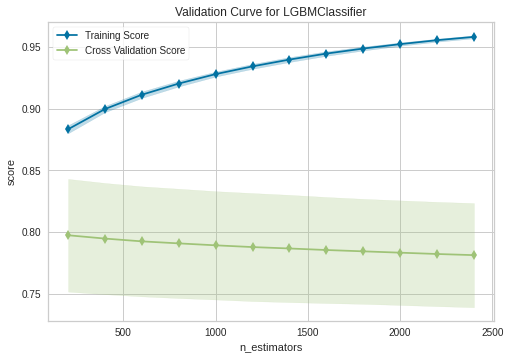

In [204]:
# Validation Curve

lgb_yb = LGBMClassifier()

visualizer = ValidationCurve(
    lgb_yb, param_name = 'n_estimators', param_range =[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400], cv=10, scoring='roc_auc')

visualizer.fit(final_train_X, final_train_y)        # Fit the data to the visualizer
visualizer.show();

In [ ]:
lgb_yb = LGBMClassifier()

visualizer = LearningCurve(
    lgb_yb, param_name = 'n_estimators', param_range =[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400], cv=10, scoring='roc_auc', train_sizes=lc[0], n_jobs=4
)

visualizer.fit(final_train_X, final_train_y)        # Fit the data to the visualizer
visualizer.show();

In [183]:
final_model = LGBMClassifier(n_estimators=1600)
final_model.fit(final_train_X, final_train_y)

LGBMClassifier(n_estimators=1600)

In [ ]:
lgb = LGBMClassifier(n_estimators = 1000, class_weight={0:1, 1:0.55})

param_grid = {'max_depth': np.arange(5,20),
             'min_child_samples' : np.arange(5,30),
             'learning_rate': np.arange(0.001, 0.1, 0.005),
             'num_leaves': np.arange(10, 30)} # {'num_leaves': 13, 'min_child_samples': 28, 'max_depth': 9, 'learning_rate': 0.006} # 0.7967939748853456

lgb_cv = RandomizedSearchCV(lgb, param_grid, cv=2, scoring='roc_auc', n_iter=20, n_jobs=-1) 
lgb_cv.fit(final_train_X, final_train_y)

In [892]:
preds #877909
test_ids #877989

0           108
1           108
2           108
3           108
4           108
           ... 
2324809    7509
2324810    7509
2324811    7509
2324812    7509
2324813    7509
Name: unique_id, Length: 877909, dtype: int64

# Create Predictions

In [184]:
# For LightGBM
preds = final_model.predict_proba(final_test_X)[:,1]

In [2]:
# For AutoML
preds = automl_pred['p1']
automl_pred = preds.as_data_frame()

NameError: name 'automl_pred' is not defined

In [3]:
# Common for both

In [1201]:
results = pd.DataFrame({'id': list(onehot_test_ids),
                       'prob':list(preds)})

In [1202]:
results['prob'].mean()

1.0

In [1174]:
pd.options.display.float_format = '{:.4f}'.format
results

,id,prob
0,9,0.9621
1,18,0.9615
2,21,0.9671
3,25,0.9841
4,31,0.9742
...,...,...
2375,7982,0.5853
2376,7990,0.4276
2377,7993,0.4613
2378,7994,0.5185


In [1175]:
expected_id.tail(5)

,unique_id
2375,7982
2376,7990
2377,7993
2378,7994
2379,7998


In [1176]:
expected = expected_id['unique_id']

In [1177]:
preds = results.groupby('id').apply(np.mean)['prob']

In [1178]:
preds

id
9      0.9621
18     0.9615
21     0.9671
25     0.9841
31     0.9742
        ...  
7982   0.5853
7990   0.4276
7993   0.4613
7994   0.5185
7998   0.4598
Name: prob, Length: 2380, dtype: float64

In [1179]:
array_0 = np.array(preds).round(6).astype(str)
final_0 = ", ".join(list(array_0))

In [1180]:
final_0

'0.962103, 0.961534, 0.967094, 0.984083, 0.974208, 0.983921, 0.950656, 0.307145, 0.576948, 0.975841, 0.356636, 0.084387, 0.951417, 0.98649, 0.976529, 0.976415, 0.445073, 0.12022, 0.961986, 0.97302, 0.962645, 0.848752, 0.981557, 0.969937, 0.977491, 0.994073, 0.913915, 0.974721, 0.935646, 0.95762, 0.982128, 0.965702, 0.962886, 0.936615, 0.925219, 0.97454, 0.750289, 0.687991, 0.967936, 0.963946, 0.961775, 0.912914, 0.935763, 0.980881, 0.972861, 0.96817, 0.99118, 0.543053, 0.416366, 0.238683, 0.403922, 0.978805, 0.948943, 0.10627, 0.378291, 0.126745, 0.984212, 0.961637, 0.983568, 0.981926, 0.983505, 0.842396, 0.120782, 0.981706, 0.990331, 0.827641, 0.974982, 0.966465, 0.969189, 0.987154, 0.99282, 0.908851, 0.967674, 0.971312, 0.965339, 0.72453, 0.930647, 0.983319, 0.957439, 0.874659, 0.262463, 0.911089, 0.990256, 0.273899, 0.982406, 0.973946, 0.758133, 0.981508, 0.980113, 0.962827, 0.987907, 0.932363, 0.707855, 0.976905, 0.188835, 0.925003, 0.948547, 0.949065, 0.461994, 0.981317, 0.975484,